In [19]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import hinge_loss
from AEspeech import AEspeech
import pdb
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.svm import SVC
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import joblib

In [20]:
"""
Specify rep choice: <'narrowband', 'broadband', 'wvlt', 'early_fuse', 'late_fuse', 'mc_fuse' (multi-channel fusion)>
"""

PATH=os.getcwd()

mod="CAE"
rep='mc_fuse'

if rep in ['narrowband', 'broadband', 'wvlt']:
    trainRes_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'_aggTrainResults.pkl'
    testRes_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'_aggTestResults.pkl'
    trainRes=pd.read_pickle(trainRes_path)
    testRes=pd.read_pickle(testRes_path)

if rep=='mc_fuse':
    trMCResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'ind_mcFusion_trainResults.pkl'
    tstMCResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'ind_mcFusion_testResults.pkl'
    trainRes=pd.read_pickle(trMCResultsPath)
    testRes=pd.read_pickle(tstMCResultsPath)
    rep='multi-channel fusion - narrowband/broadband'

if rep=='early_fuse':
    trEFResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'_earlyFusion_trainResults.pkl'
    tstEFResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'_earlyFusion_testResults.pkl'
    trainRes=pd.read_pickle(trEFResultsPath)
    testRes=pd.read_pickle(tstEFResultsPath)
    rep='early fusion - narrowband/broadband'

if rep=='late_fuse':
    trLFResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'_lateFusion_trainResults.pkl'
    tstLFResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'_lateFusion_testResults.pkl'
    trainRes=pd.read_pickle(trLFResultsPath)
    testRes=pd.read_pickle(tstLFResultsPath)
    rep='late fusion - narrowband/broadband'

mfda_path=PATH+"/pdSpanish/"
mfdas=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")['M-FDA'].values
pd_mfdas=mfdas[0:50]
hc_mfdas=mfdas[50:]

In [21]:
avgAggResults={spk:{} for spk in ['pd','hc']}
for idx in testRes.index:
    for col in testRes.columns:
        if col=='tstSpk_data':
            if idx<20:
                avgAggResults['pd'][idx]=testRes[col][idx]
            else:
                avgAggResults['hc'][idx]=testRes[col][idx]                                                                            

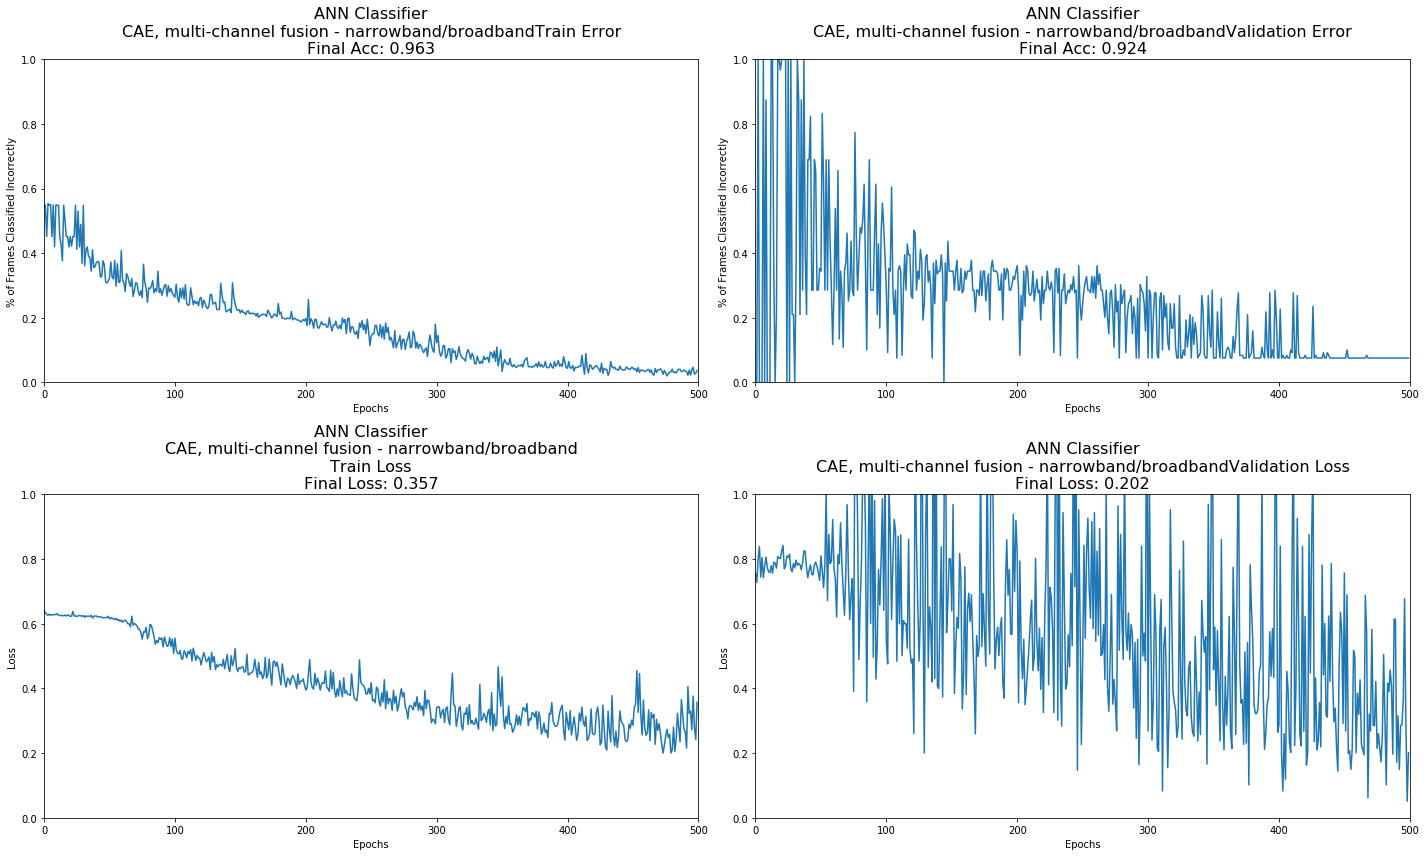

In [22]:
train_acc=0
val_acc=0
train_loss=0
nb_train_loss=0
bb_train_loss=0
val_loss=0
num_itrs=trainRes.index[-1][0]+1

for i in range(num_itrs):
    train_acc+=trainRes['train_acc'][i]/num_itrs
    val_acc+=trainRes['val_acc'][i]/num_itrs
    if rep=='late fusion - narrowband/broadband':
        bb_train_loss+=trainRes['bb_train_loss'][i]/num_itrs
        nb_train_loss+=trainRes['nb_train_loss'][i]/num_itrs
    else:
        train_loss+=trainRes['train_loss'][i]/num_itrs
        val_loss+=trainRes['val_loss'][i]/num_itrs 

fig,ax=plt.subplots(2,2,figsize=(20, 12))

ax[0][0].plot(1-train_acc)
ax[0][0].set_title("ANN Classifier\n"+mod+", "+
          rep+'Train Error\nFinal Acc: '+str(np.round(train_acc.iloc[-1],3)), fontsize=16)
ax[0][0].set_xlabel("Epochs")
ax[0][0].set_ylabel("% of Frames Classified Incorrectly")
ax[0][0].set_xlim([0,train_acc.size])
ax[0][0].set_ylim([0,1])

ax[0][1].plot(1-val_acc)
ax[0][1].set_title("ANN Classifier\n"+mod+", "+
          rep+'Validation Error\nFinal Acc: '+str(np.round(val_acc.iloc[-1],3)), fontsize=16)
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("% of Frames Classified Incorrectly")
ax[0][1].set_xlim([0,train_acc.size])
ax[0][1].set_ylim([0,1])

if rep=='late fusion - narrowband/broadband':
    ax[1][0].plot(bb_train_loss)
    ax[1][0].set_title("ANN Classifier\n"+mod+", "+
          rep+'Broadband Train Loss\nFinal Loss: '+str(np.round(bb_train_loss.iloc[-1],3)), fontsize=16)
    ax[1][0].set_xlabel("Epochs")
    ax[1][0].set_ylabel("Loss")
    ax[1][0].set_xlim([0,train_acc.size])
    ax[1][0].set_ylim([0,1])
    
    ax[1][1].plot(nb_train_loss)
    ax[1][1].set_title("ANN Classifier\n"+mod+", "+
          rep+'Narrowband Train Loss\nFinal Loss: '+str(np.round(nb_train_loss.iloc[-1],3)), fontsize=16)
    ax[1][1].set_xlabel("Epochs")
    ax[1][1].set_ylabel("Loss")
    ax[1][1].set_xlim([0,train_acc.size])
    ax[1][1].set_ylim([0,1])

else:
    ax[1][0].plot(train_loss)
    ax[1][0].set_title("ANN Classifier\n"+mod+", "+
          rep+'\nTrain Loss\nFinal Loss: '+str(np.round(train_loss.iloc[-1],3)), fontsize=16)
    ax[1][0].set_xlabel("Epochs")
    ax[1][0].set_ylabel("Loss")
    ax[1][0].set_xlim([0,train_acc.size])
    ax[1][0].set_ylim([0,1])
    
    ax[1][1].plot(val_loss)
    ax[1][1].set_title("ANN Classifier\n"+mod+", "+
          rep+'Validation Loss\nFinal Loss: '+str(np.round(val_loss.iloc[-1],3)), fontsize=16)
    ax[1][1].set_xlabel("Epochs")
    ax[1][1].set_ylabel("Loss")
    ax[1][1].set_xlim([0,train_acc.size])
    ax[1][1].set_ylim([0,1])

plt.tight_layout()

In [23]:
y_score=np.zeros((40,2))
y_test=np.zeros((40,2))
thresh=0

for i in range(40):
    if i<20:
        y_score[i,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
        y_test[i,:]=np.vstack((np.zeros(1),np.ones(1))).T
    else:
        y_score[i,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
        y_test[i,:]=np.vstack((np.ones(1),np.zeros(1))).T

Text(0.5, 1.0, 'ANN Classifier\n Difference in Classification Probability\nCAE, multi-channel fusion - narrowband/broadband\nOverall Test Acc: 0.575\nPrecision: 0.594 Recall: 0.575')

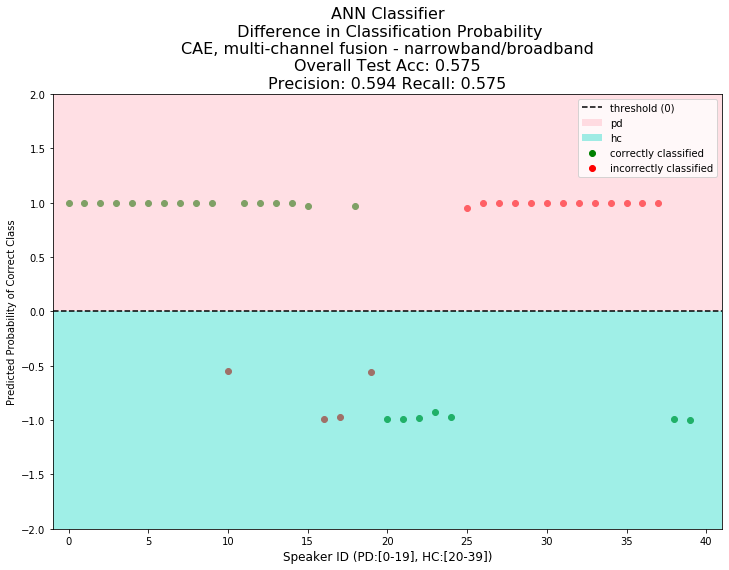

In [24]:
"""Prediction based on difference between predicted class probs."""
# poly=np.polyfit(mfdas, y_score[:,1]-y_score[:,0], 1)
x_lin_reg = range(-2, 53)
# predict = np.poly1d(poly)
# cor=stats.spearmanr(mfdas, y_score[:,1]-y_score[:,0])
precision=precision_score(np.concatenate((np.ones(20),np.zeros(20))), np.ceil(y_score[:,1]-y_score[:,0]), average='macro')
recall=recall_score(np.concatenate((np.ones(20),np.zeros(20))), np.ceil(y_score[:,1]-y_score[:,0]), average='macro')

plt.figure(figsize=(12,8))
correct_idx=np.concatenate((np.where((y_score[0:20,1]-y_score[0:20,0])>0)[0],np.where((y_score[20:,1]-y_score[20:,0])<0)[0]+20))
incorrect_idx=np.concatenate((np.where((y_score[0:20,1]-y_score[0:20,0])<0)[0],np.where((y_score[20:,1]-y_score[20:,0])>0)[0]+20))
plt.scatter(correct_idx,(y_score[:,1]-y_score[:,0])[correct_idx],c='g' )
plt.scatter(incorrect_idx,(y_score[:,1]-y_score[:,0])[incorrect_idx],c='r' )
plt.axhline(y=thresh, color='black', linestyle='--',label="optimal threshold")
plt.axhspan(thresh, 2, color='pink', alpha=0.5, lw=0)
plt.axhspan(-2, thresh, color='turquoise', alpha=0.5, lw=0)
plt.legend(['threshold ('+str(thresh)+')', 'pd', 'hc', 'correctly classified', 'incorrectly classified'])
plt.xlim([-1,41])
plt.ylim([-2,2])
plt.xlabel('Speaker ID (PD:[0-19], HC:[20-39])',fontsize=12)
plt.ylabel('Predicted Probability of Correct Class')
plt.title('ANN Classifier\n Difference in Classification Probability\n'+mod+", "+
          rep+'\nOverall Test Acc: '+str(correct_idx.shape[0]/40)+
          "\nPrecision: "+str(np.round(precision,3))+" Recall: "+str(np.round(recall,3)), fontsize=16)
    

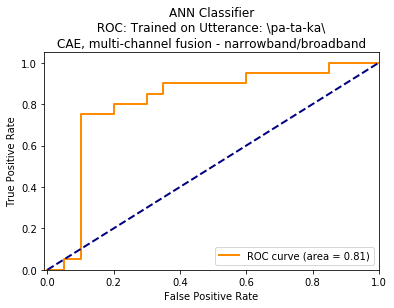

In [12]:
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test[:, i]), np.array(y_score[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN Classifier\n ROC: Trained on Utterance: \pa-ta-ka\ \n'+mod+", "+rep)
plt.legend(loc="lower right")